In [1]:
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [2]:
import sys
sys.path.append('..\..\early-stopping-pytorch')
from pytorchtools import EarlyStopping

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Adjust printing view dimensions
np.set_printoptions(threshold=sys.maxsize, linewidth=300)
#torch.set_printoptions(threshold=sys.maxsize, linewidth=300, profile='full')

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.input_shape = kwargs["input_shape"]
        # number of hidden units in first hidden layer
        self.n_units = kwargs["n_units"]
        self.latent_units = kwargs["latent_units"]
        
        self.encoder = torch.nn.Sequential(
            # Linear(): Initiate a linear function theta*x + b
            nn.Linear(in_features=self.input_shape, out_features=self.n_units),
            torch.nn.ReLU(),
            nn.Linear(in_features=self.n_units, out_features=self.latent_units),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            nn.Linear(in_features=self.latent_units, out_features=self.n_units),
            torch.nn.ReLU(),
            nn.Linear(in_features=self.n_units, out_features=self.input_shape),
            torch.nn.Sigmoid()
        )
    
    # X denotes features
    def forward(self, X):
        encode = self.encoder(X)
        decode = self.decoder(encode)
        return decode

In [4]:
class SparseAutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.input_shape = kwargs["input_shape"]
        # number of hidden units in first hidden layer
        self.n_units = kwargs["n_units"]
        # number of hidden units in latent space
        self.latent_units = kwargs["latent_units"]
        
        self.encoder = torch.nn.Sequential(
            nn.Linear(in_features=self.input_shape, out_features=self.n_units),
            torch.nn.ReLU()
        )
        # Bottleneck is actually in the encoder, but it must be isolated in order to calculate sparsity
        self.bottleneck = torch.nn.Sequential(
            nn.Linear(in_features=self.n_units, out_features=self.latent_units),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            nn.Linear(in_features=self.latent_units, out_features=self.n_units),
            torch.nn.ReLU(),
            nn.Linear(in_features=self.n_units, out_features=self.input_shape),
            torch.nn.Sigmoid()
        )
    
    # X denotes features
    def forward(self, X):
        encoded = self.encoder(X)
        bottleneck = self.bottleneck(encoded)
        decoded = self.decoder(bottleneck)
        return bottleneck, decoded

In [5]:
# 10,000 samples, 30x30 matrices
is_pca = False
data = np.ndarray(shape=(10000,30,30))
n_features = data.shape[1] * data.shape[2]


for i in range(10000):
    path = f'data/jet_matrices/sample{i+1}.dat'
    sample = np.loadtxt(path, unpack = False)
    data[i] = sample

print("Done loading data.")

Done loading data.


In [7]:
# Flatten data and convert to Torch Tensor

# 10,000 samples, 900 features
X = np.ndarray(shape=(10000, n_features))
for i, sample in enumerate(data):
    flat = sample.flatten()
    X[i] = flat
    #print(X[i])

# Convert from numpy array to Pytorch tensor
X = torch.from_numpy(X)
# Convert all scalars to floats. May affect training behavior (ie. reconstructions made of non-binary scalar values)
X = X.float()

## PCA

In [ ]:
def de_correlate_data(X):
    X_pert = np.copy(X)
    i = 0
    for col in X.T:
        #print(col)
        X_pert[:,i] = np.random.permutation(col)
        #print(X_pert[:,i])
        i += 1
        
    return X_pert

# # function demo
# z = np.array([[1,2,3],[4,5,6],[7,8,9]])
# #z = np.array([[0,1,0],[1,0,1],[1,1,1]])
# print(z)
# X_pert = de_correlate_data(z)
# print(X_pert)

In [ ]:
# Plot cumulative explained variance w.r.t. number of components

def pca_run(X):
    pca = PCA(n_components=0.95).fit(X)

    #% matplotlib inline
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    y = np.cumsum(pca.explained_variance_ratio_)
    # n_components = number of components needed to reach cum. variance threshold
    n_components = y.size
    xi = np.arange(1, n_components+1, step=1)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    #change from 0-based array index to 1-based human-readable label
    plt.xticks(np.arange(0, n_components+1, step=1))
    plt.ylabel('Cumulative variance (%)')
    plt.title('The Number of Components Needed to Explain Variance')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.axhline(y=0.8, color='g', linestyle='-')
    plt.axhline(y=0.9, color='b', linestyle='-')
    plt.text(0, 0.915, '95% cut-off threshold', color = 'red', fontsize=13)
    plt.text(24, 0.85, '90% cut-off threshold', color = 'blue', fontsize=13)
    plt.text(12, 0.75, '80% cut-off threshold', color = 'green', fontsize=13)

    ax.grid(axis='x')
    plt.show()

# Run with original data.
pca_run(X.numpy())

# Run with permutated data.
# De-correlates features, so performing worse than original data indicates
# existence of correlation in the original data's features.
X_pert = de_correlate_data(X)
pca_run(X_pert)

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
plt.bar(xi, pca.explained_variance_ratio_, width=0.4)
plt.ylabel("Percent of Total Variance")
plt.xlabel("Principal Component")
plt.title("Significance of Each Principal Component Towards Variance ")

In [ ]:
# PCA

# Toggle to indicate to training that PCA is in use
is_pca = True
# -- DEFINE NUMBER OF COMPONENTS HERE --
n_components = 5

pca = PCA(n_components=n_components).fit(X.numpy())

print(X)
# If fails, re-run "Flatten data..." cell
X_pca = pca.fit_transform(X)
X_pca = torch.from_numpy(X_pca)
# Convert all scalars to floats. May affect training behavior (ie. reconstructions made of non-binary scalar values)
X_pca = X_pca.float()
# Replace former n_features with number of components
n_features = X_pca.shape[1]

## Training & Validation

In [9]:
# Hyperparameters

# Changes X based on whether PCA was used
if is_pca:
    X_2 = X_pca
else:
    X_2 = X

batch_size = 32
# 70/15/15 split
train_size = int(0.7 * len(X_2))
val_size = len(X_2) - train_size
test_size = val_size // 2

In [10]:
# Initate data loaders

train, val = torch.utils.data.random_split(X_2, [train_size, val_size])
val, test = torch.utils.data.random_split(val, [test_size, test_size])

train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

# Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
#############################    
#   TRAINING & VALIDATION   #
#############################

class ExceededRangeError(Exception):
    """Raised when values outside range [0.0, 1.0] are found in BCE loss"""
    pass

# Training and Validation are combined in order to allow for early stopping
def train_validate(model, epochs, lr, is_early_stopping=False, is_pca=False, is_sparse=False, patience=None, beta=None, rho=None):
    # Define Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Binary Cross Entropy Loss
    criterion = nn.BCELoss()
    # See pytorch docs on why reduction is batch mean.
    kl_divergence = nn.KLDivLoss(reduction="batchmean", log_target=False)

    # Reset model state if previously trained
    torch.manual_seed(1)
    def weights_init(m):
        if isinstance(m, torch.nn.Linear):
            nn.init.xavier_uniform_(m.weight.data)
            print("existing instance")

    model.apply(weights_init)

    # Toggle Early Stopping (if using).
    if is_early_stopping:
        early_stopping = EarlyStopping(patience=patience, verbose=True)
        print("Using Early Stopping")
    if is_pca:
        print("Using PCA")

    print("Training...")
    for epoch in range(epochs):
        
        #############################    
        #          TRAINING         #
        #############################
        
        loss = 0
        # Prepare model for training
        model.eval()
        train_losses = []
        for i, batch in enumerate(train_loader, 0):

            # reshape mini-batch data from [batch_size, 30, 30] to [batch_size, 900]
            # load it to the active device
            batch = batch
            batch = batch.view(-1, n_features).to(device)

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            # also retrieve bottleneck weights for computing sparsity penalty
            bottleneck, decoded = model(batch)

            # Exception handler for when BCE loss has values outside range [0.0, 1.0]
            try:
                # compute training reconstruction loss
                train_loss = criterion(decoded, batch)
            except RuntimeError:
                print('Runtime Error during loss calculation. BCE loss has values outside range [0.0, 1.0]')
                for k, sample in enumerate(decoded):
                    print(k)
                    print(sample)
                    
            # add sparsity penalty to loss, if toggled
            if is_sparse:
                rho_hat = torch.sum(bottleneck, dim=0, keepdim=True)
                # the input KL Divergence must be in log space and in a distribution, hence log & softmax.
                rho_hat = torch.nn.functional.log_softmax(rho_hat, dim=1)
                # Converting target to softmax in our case is unecessary because rho is the same for all values,
                # thus no change occurs. However, we do need to convert target to log-space due to a PyTorch bug.
                rho_soft = torch.nn.functional.log_softmax(rho, dim=1)
                s = kl_divergence(rho_hat, rho_soft)
                
                # Potential alternative KL divergence implementation
                # nn.functional.softmax(b, dim=1) * (nn.functional.log_softmax(b, dim=1) - nn.functional.log_softmax(rho_hat, dim=1))
                
                sparsity_penalty = beta * s
                train_loss = train_loss + sparsity_penalty
                # Check whether KL divergence is behaving correctly (ie. should be nonnegative).
                if torch.all(sparsity_penalty < 0):
                    print('Error: sparsity penalty is negative.')
                    print(f'rho: {rho_soft}')
                    print(f'rho_hat: {rho_hat}')
                    print(f'sparsity: {sparsity_penalty}')
                    print(f'training loss: {train_loss}')

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            train_losses.append(train_loss.item())

        # compute the epoch training loss
        avg_train_loss = np.average(train_losses)

        #############################    
        #         VALIDATION        #
        #############################

        # Decoupled into three lists due to issue with placing torch tensors into multidimensional lists
        batches = []
        recons = []
        val_losses = []

        # Prepare model for evaluation
        model.eval()

        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for i, batch in enumerate(val_loader, 0):
                batch = batch.view(-1, n_features).to(device)
                bottleneck, reconstructions = model(batch)
                # Reconstruction loss
                val_loss = criterion(reconstructions, batch)
                # Store samples, predictions, and loss for visualization purposes
                batches.append(batch)
                recons.append(reconstructions)
                val_losses.append(val_loss.item())
                #print(f'Batch {i}: {val_loss.item()}')

        avg_val_loss = np.average(val_losses)
        
        # display the epoch training loss and validation loss
        print("Epoch : {}/{}, Training Loss = {:.6f}, Validation Loss = {:.6f}".format(epoch + 1, epochs, avg_train_loss, avg_val_loss))
        
        opt_epochs = epochs
        
        if is_early_stopping:
            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                opt_epochs = epoch + 1
                print("Early stopping...")
                # Exit training loop
                break
        else:
            torch.save(model.state_dict(), 'checkpoint.pt')
    
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    print(f"Epochs: {opt_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")
    
    return  model, avg_train_loss, avg_val_loss, opt_epochs

In [17]:
# BASIC AUTOENCODER Execute training & validating

lr = 1e-3
epochs = 5
# number of hidden units in encoder hidden layer
n_units = 50
# number of hidden units in latent space
latent_units = 4
# Boolean for whether to use Early Stopping
is_early_stopping = False
# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

basic_model = SparseAutoEncoder(input_shape=n_features,
                    n_units=n_units,
                    latent_units=latent_units
                   ).to(device)

basic_model, avg_train_loss, avg_val_loss, opt_epochs = train_validate(model=basic_model,
                                                                        epochs=epochs,
                                                                        lr=lr,
                                                                        is_early_stopping=is_early_stopping, 
                                                                        is_pca=is_pca,
                                                                        patience=patience)


existing instance
existing instance
existing instance
existing instance
Training...
Epoch : 1/5, Training Loss = 0.118476, Validation Loss = 0.036027
Epoch : 2/5, Training Loss = 0.033188, Validation Loss = 0.032406
Epoch : 3/5, Training Loss = 0.030611, Validation Loss = 0.027383
Epoch : 4/5, Training Loss = 0.017577, Validation Loss = 0.013931
Epoch : 5/5, Training Loss = 0.012241, Validation Loss = 0.012211
Epochs: 5, Training Loss: 0.01224080600337759, Validation Loss: 0.01221062506529245


In [22]:
# SPARSE AUTOENCODER Execute training & validating
lr = 1e-3
epochs = 200
n_units = 50
latent_units = 20
is_early_stopping = True
# early stopping patience; how long to wait after last time validation loss improved.
patience = 5

is_sparse = True
beta = 2
rho = 0.05
rho_tensor = torch.FloatTensor([rho for _ in range(latent_units)]).unsqueeze(0)
rho_tensor = rho_tensor.to(device)

sparse_model = SparseAutoEncoder(input_shape=n_features,
                    n_units=n_units,
                    latent_units=latent_units
                   ).to(device)

avg_values = []
sparse_model, avg_train_loss, avg_val_loss, opt_epochs = train_validate(model=sparse_model,
                                                    epochs=epochs,
                                                    lr=lr,
                                                    is_early_stopping=is_early_stopping, 
                                                    is_pca=is_pca,
                                                    is_sparse=is_sparse,
                                                    patience=patience,
                                                    beta=beta,
                                                    rho=rho_tensor)

existing instance
existing instance
existing instance
existing instance
Using Early Stopping
Training...
Epoch : 1/200, Training Loss = 0.097116, Validation Loss = 0.034743
Validation loss decreased (inf --> 0.034743).  Saving model ...
Epoch : 2/200, Training Loss = 0.030651, Validation Loss = 0.023088
Validation loss decreased (0.034743 --> 0.023088).  Saving model ...
Epoch : 3/200, Training Loss = 0.015933, Validation Loss = 0.013342
Validation loss decreased (0.023088 --> 0.013342).  Saving model ...
Epoch : 4/200, Training Loss = 0.011954, Validation Loss = 0.011829
Validation loss decreased (0.013342 --> 0.011829).  Saving model ...
Epoch : 5/200, Training Loss = 0.011057, Validation Loss = 0.011542
Validation loss decreased (0.011829 --> 0.011542).  Saving model ...
Epoch : 6/200, Training Loss = 0.010475, Validation Loss = 0.010800
Validation loss decreased (0.011542 --> 0.010800).  Saving model ...
Epoch : 7/200, Training Loss = 0.010129, Validation Loss = 0.010992
EarlyStopp

In [ ]:
avg_weights = []
for neuron in sparse_model.state_dict()['bottleneck.0.weight']:
    avg = torch.mean(neuron)
    avg_weights.append(avg)
avg_weights

# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

In [ ]:
sum = 0
for i in avg_weights:
    sum += i
sum

## Testing

In [19]:
def test(model, n_features):
    # Decoupled into three lists due to issue with placing torch tensors into multidimensional lists
    batches = []
    recons = []
    test_losses = []
    criterion = nn.BCELoss()

    # Prepare model for evaluation
    model.eval()

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, batch in enumerate(test_loader, 0):
            #batch = batch.view(-1, n_features).to(device)
            batch = batch.to(device)
            bottleneck, reconstructions = model(batch)
            # Reconstruction loss
            test_loss = criterion(reconstructions, batch)
            # Store samples, predictions, and loss for visualization purposes
            batches.append(batch)
            recons.append(reconstructions)
            test_losses.append(test_loss.item())
            print(f'Batch {i}: {test_loss.item()}')

    avg_test_loss = np.average(test_losses)
    print(f"Average Test Reconstruction Loss: {avg_test_loss}")
    
    return batches, recons, test_losses

In [ ]:
t1 = torch.tensor(np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]]))
t2 = t1.view(-1, 6)
print(t1.size())
print(t2.size())
print(t1)
print(t2)

In [20]:
batches, recons, test_losses = test(sparse_model, n_features)

Batch 0: 0.009264632128179073
Batch 1: 0.009027695283293724
Batch 2: 0.011478169821202755
Batch 3: 0.009944290854036808
Batch 4: 0.009928877465426922
Batch 5: 0.015186087228357792
Batch 6: 0.010248222388327122
Batch 7: 0.0097123384475708
Batch 8: 0.0122562600299716
Batch 9: 0.012277242727577686
Batch 10: 0.011190252378582954
Batch 11: 0.015765396878123283
Batch 12: 0.010712776333093643
Batch 13: 0.009428486227989197
Batch 14: 0.010405373759567738
Batch 15: 0.012427356094121933
Batch 16: 0.009974771179258823
Batch 17: 0.01160620991140604
Batch 18: 0.010054763406515121
Batch 19: 0.010156034491956234
Batch 20: 0.008843005634844303
Batch 21: 0.009226149879395962
Batch 22: 0.008921321481466293
Batch 23: 0.009444725699722767
Batch 24: 0.019819850102066994
Batch 25: 0.009245255030691624
Batch 26: 0.01133140828460455
Batch 27: 0.011385300196707249
Batch 28: 0.007388158701360226
Batch 29: 0.009530437178909779
Batch 30: 0.009663949720561504
Batch 31: 0.00928716454654932
Batch 32: 0.0112311467528

In [ ]:
batches, recons, test_losses = test(basic_model, n_features)

## Visualization

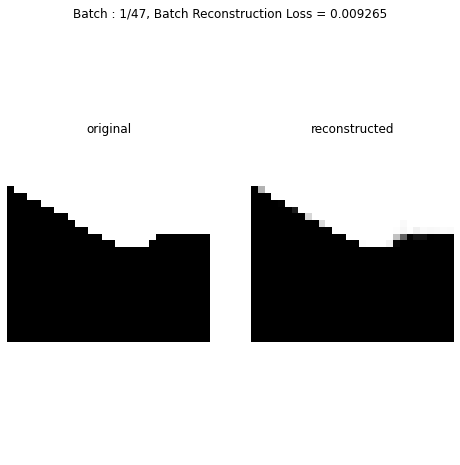

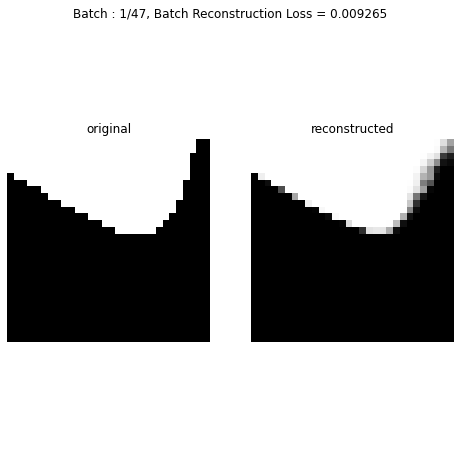

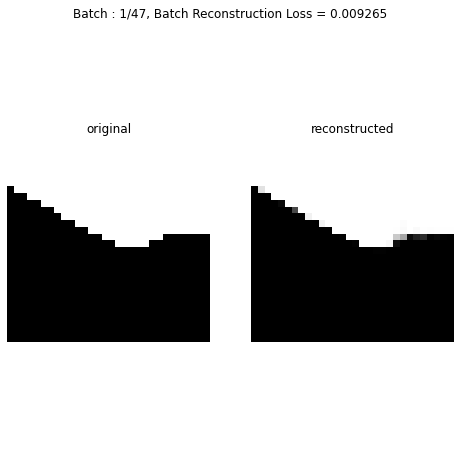

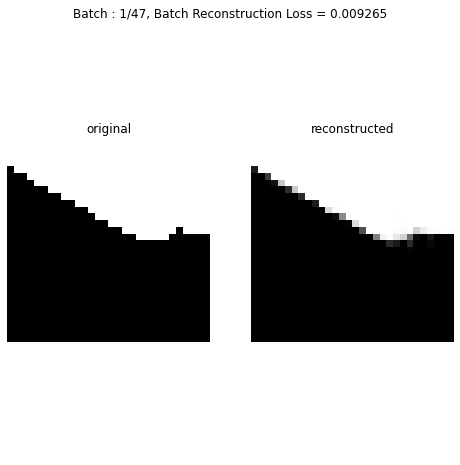

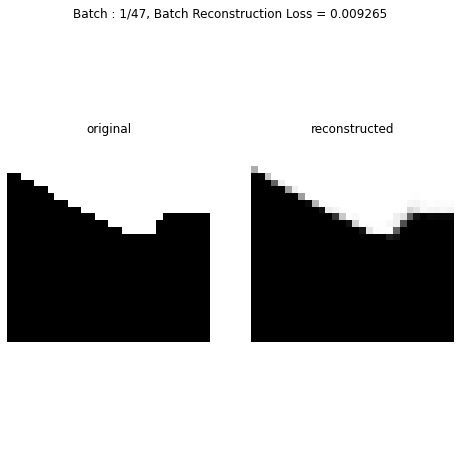

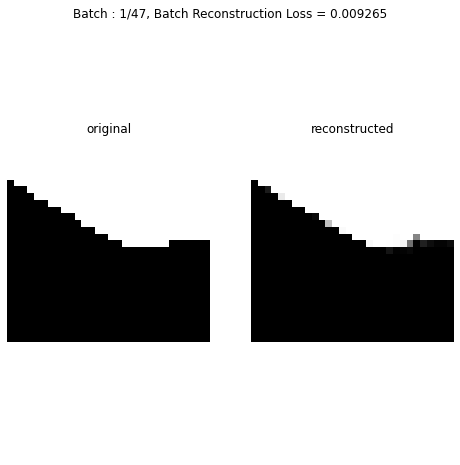

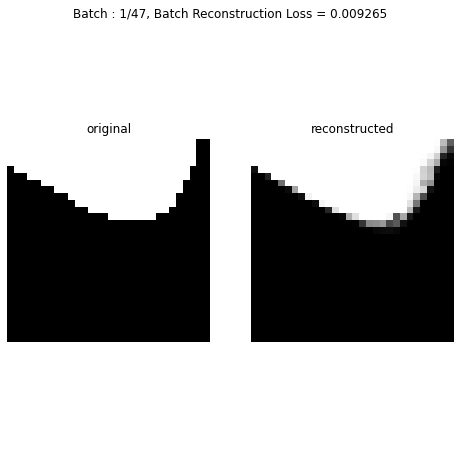

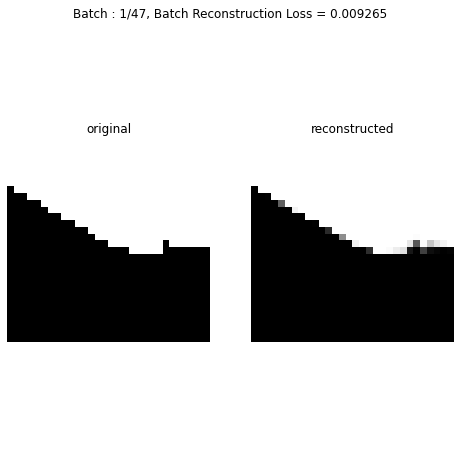

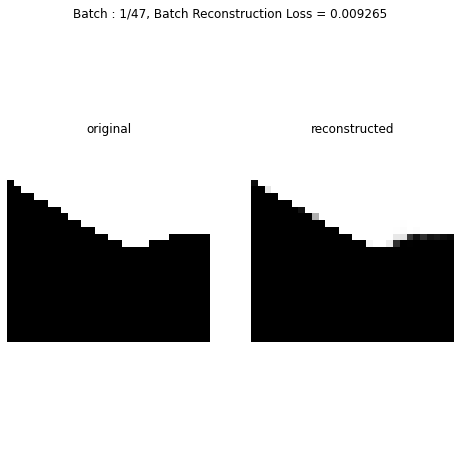

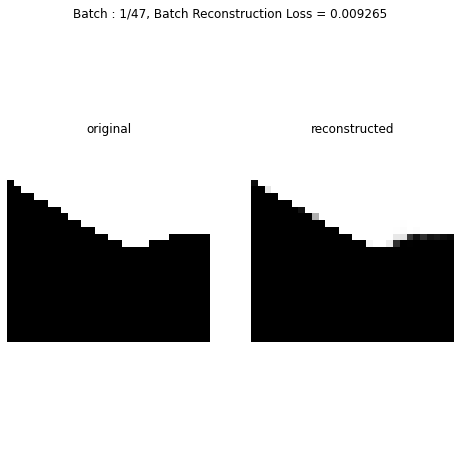

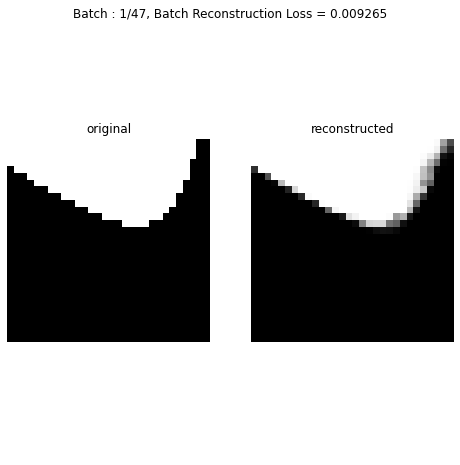

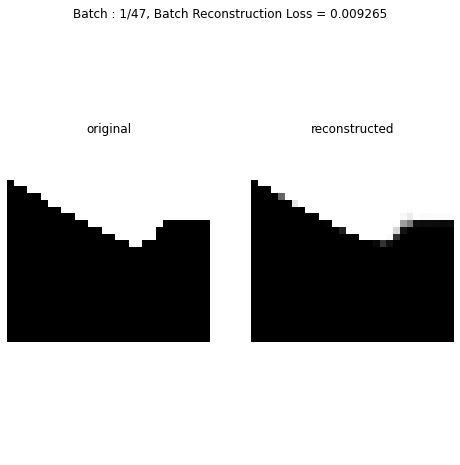

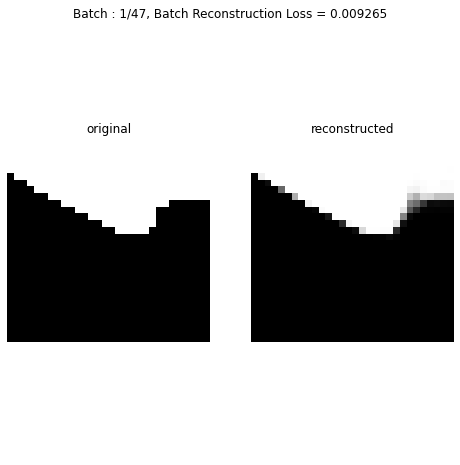


KeyboardInterrupt



<Figure size 576x576 with 0 Axes>

In [21]:
# Visualization

for i in range(len(recons)):
    loss = test_losses[i]
    batch = batches[i]
    reconstructions = recons[i]
    # Iterate through all examples in ith batch
    for j in range(len(batch)):
        # Reshape original example for plotting back into 30x30
        # or keep as vector of components if using PCA.
        if is_pca:
            original = batch[j].reshape(1, n_features)
        else:
            original = batch[j].reshape(data.shape[1], data.shape[2])
        original = original.cpu()
        # Reshape reconstructed example for plotting
        # or keep as vector of components if using PCA.
        if is_pca:
            reconstruction = reconstructions[j].reshape(1, n_features)
        else:
            reconstruction = reconstructions[j].reshape(data.shape[1], data.shape[2])
        reconstruction = reconstruction.cpu()
        
        fig = plt.figure(figsize=(8, 8))
        plt.title("Batch : {}/{}, Batch Reconstruction Loss = {:.6f}".format(i+1, len(recons), loss))
        plt.axis('off')
        # display original
        fig.add_subplot(1, 2, 1)
        plt.imshow(original)
        plt.axis('off')
        plt.title("original")
        plt.gray()
        
        # fig.get_xaxis().set_visible(False)
        # fig.get_yaxis().set_visible(False)

        # display reconstruction
        fig.add_subplot(1, 2, 2)
        plt.imshow(reconstruction)
        plt.axis('off')
        plt.title("reconstructed")
        plt.gray()
        # fig.get_xaxis().set_visible(False)
        # fig.get_yaxis().set_visible(False)
        plt.show()